In [29]:
!mkdir /Users/nizheng/Desktop/Study/STAT\ 479/project
!mkdir /Users/nizheng/Desktop/Study/STAT\ 479/project/models
!cp /Users/nizheng/Downloads/keras-pretrained-models/*notop* /Users/nizheng/Desktop/Study/STAT\ 479/project/models/
!cp /Users/nizheng/Downloads/keras-pretrained-models/imagenet_class_index.json /Users/nizheng/Desktop/Study/STAT\ 479/project/models/
!cp /Users/nizheng/Downloads/keras-pretrained-models/resnet50* /Users/nizheng/Desktop/Study/STAT\ 479/project/models/
!cp /Users/nizheng/Desktop/mias-mammography/ /Users/nizheng/Desktop/Study/STAT\ 479/project/

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
cp: /Users/nizheng/Desktop/mias-mammography/: No such file or directory


In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import h5py
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [31]:
os.chdir("/Users/nizheng/Desktop/Study/STAT 479/project")

In [32]:
base_h5 = os.path.join('..' ,'mias-mammography', 'all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
220,G,CALC,8.0,mdb218,B,519.0,629.0,mdb218.pgm,tiffs/mdb218.tif
6,F,NORM,NaN,mdb006,nan,NaN,NaN,mdb006.pgm,tiffs/mdb006.tif
306,F,NORM,NaN,mdb299,nan,NaN,NaN,mdb299.pgm,tiffs/mdb299.tif
134,F,NORM,NaN,mdb133,nan,NaN,NaN,mdb133.pgm,tiffs/mdb133.tif
310,F,NORM,NaN,mdb303,nan,NaN,NaN,mdb303.pgm,tiffs/mdb303.tif


In [6]:
keras.utils.np_utils?

Object `keras.utils.np_utils` not found.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x837ec0630>,
      dtype=object)

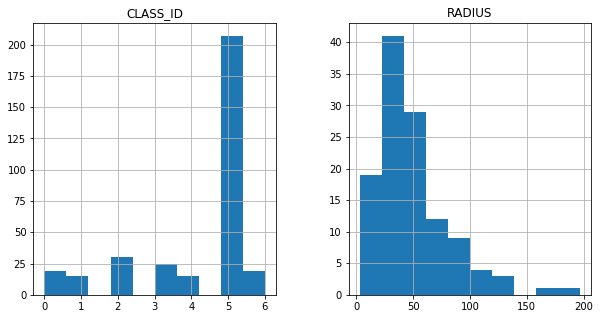

In [33]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

In [34]:
#split data into train and validation
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
58,D,MISC,27.0,mdb058,M,318.0,359.0,mdb058.pgm,tiffs/mdb058.tif,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


New Data Size: 1300 Old Size: 247


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x8372894e0>,
      dtype=object)

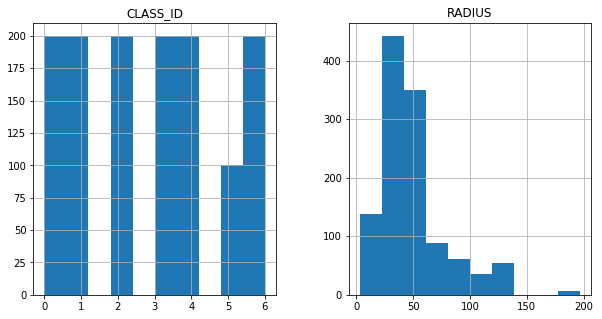

In [35]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (192, 192) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [37]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [38]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_VEC', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1300 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 83 images


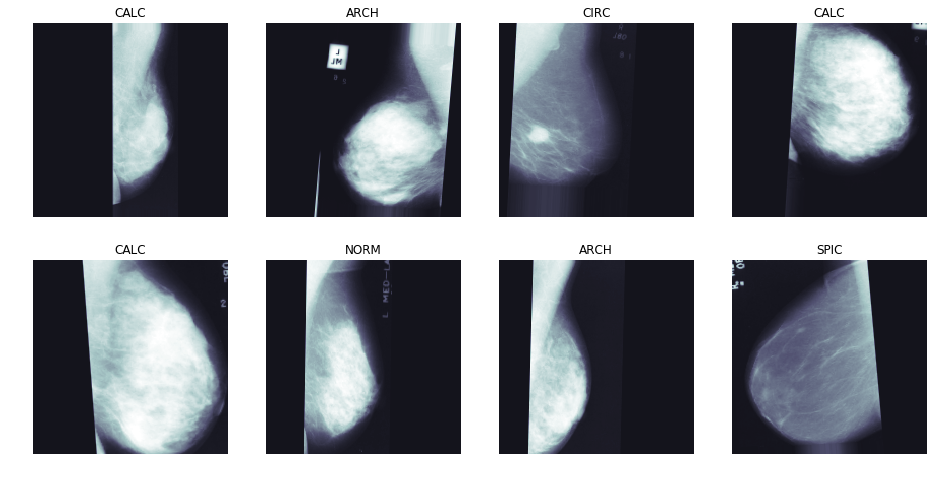

In [39]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % (class_enc.classes_[np.argmax(c_y,-1)]))
    c_ax.axis('off')

In [40]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(len(class_enc.classes_), activation = 'softmax')(dr_steps) # linear is what 16bit did
mammo_model = Model(inputs = [in_lay], outputs = [out_layer])

mammo_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

mammo_model.summary()

58892288/58889256 [==============================] - 6s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 6, 6, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 6, 6, 512)    2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 6, 6, 64)     32832       batch_normalization_2[0][0]      
____________________________________________

In [41]:
!rm -rf /Users/nizheng/Desktop/Study/STAT\ 479/project # clean up the model / make space for other things

In [42]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('mammo_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [57]:
mammo_model.fit_generator(train_gen,steps_per_epoch=35,validation_data=(test_X,test_Y),epochs=5,callbacks=callbacks_list)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch 1/5
Traceback (most recent call last):
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-1458f6bfa398>", line 1, in <module>
    mammo_model.fit_generator(train_gen,steps_per_epoch=35,validation_data=(test_X,test_Y),epochs=5,callbacks=callbacks_list)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 709, in get
    six.reraise(*sys.exc_

FileNotFoundError: [Errno 2] No such file or directory: 'tiffs/mdb299.tif'

In [54]:
mammo_model.fit_generator(train_gen, 
                                  steps_per_epoch = 35,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch 1/5
Traceback (most recent call last):
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-b03a03bb9733>", line 5, in <module>
    callbacks = callbacks_list)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 709, in get
    six.reraise(*sys.exc_info())
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/six.py", line 693, in rer

FileNotFoundError: [Errno 2] No such file or directory: 'tiffs/mdb206.tif'

In [26]:
mammo_model.load_weights(weight_path)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-3b49a5d719b6>", line 1, in <module>
    mammo_model.load_weights(weight_path)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/keras/engine/network.py", line 1157, in load_weights
    with h5py.File(filepath, mode='r') as f:
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/h5py/_hl/files.py", line 269, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, swmr=swmr)
  File "/Users/nizheng/anaconda3/lib/python3.6/site-packages/h5py/_hl/files.py", line 99, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 78, in h5py.h5f.open
OSError: Unable to open 

OSError: Unable to open file (unable to open file: name = 'mammo_result_weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)